In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from pathlib import Path
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

In [18]:
def power_law(xData, a, b):
        return a*xData**b

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[0.5, 0.5])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [2]:
dataBase_path = r'./'
dataBase_file = r'UUVDatabase.xlsx' 

In [3]:
data_path = Path(dataBase_path, dataBase_file)
bcfDF = pd.read_excel(data_path, sheet_name = 'BCF')
mpfDF = pd.read_excel(data_path, sheet_name='MPF')
convDF = pd.read_excel(data_path, sheet_name = 'Propeller')

In [4]:
conv_cot = convDF[convDF['COTopt [J/m]'].notnull()]
bcf_cot = bcfDF[bcfDF['COTopt [J/m]'].notnull()]
mpf_cot = mpfDF[mpfDF['COTopt [J/m]'].notnull()]

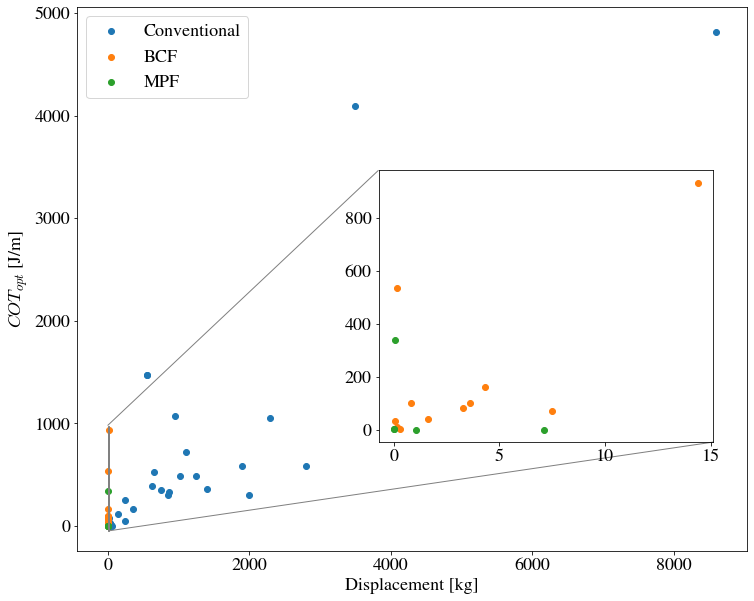

In [5]:
# Plot COT and displacement
plt.rcParams.update({'font.size':18})
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.family':'STIXGeneral'})

fig1, ax1 = plt.subplots(figsize=(12,10), facecolor='w')
ax1.scatter(conv_cot['Weight [kg]'], conv_cot['COTopt [J/m]'], color='C0', label='Conventional')
ax1.scatter(bcf_cot['Weight [kg]'], bcf_cot['COTopt [J/m]'], color='C1', label='BCF')
ax1.scatter(mpf_cot['Weight [kg]'], mpf_cot['COTopt [J/m]'], color='C2', label='MPF')
ax1.set_xlabel('Displacement [kg]')
ax1.set_ylabel('$COT_{opt}$ [J/m]')
ax1.legend()

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.45,0.2,0.5,0.5])
ax2.set_axes_locator(ip)
mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

ax2.scatter(bcf_cot['Weight [kg]'], bcf_cot['COTopt [J/m]'], color='C1', label='BCF')
ax2.scatter(mpf_cot['Weight [kg]'], mpf_cot['COTopt [J/m]'], color='C2', label='MPF')

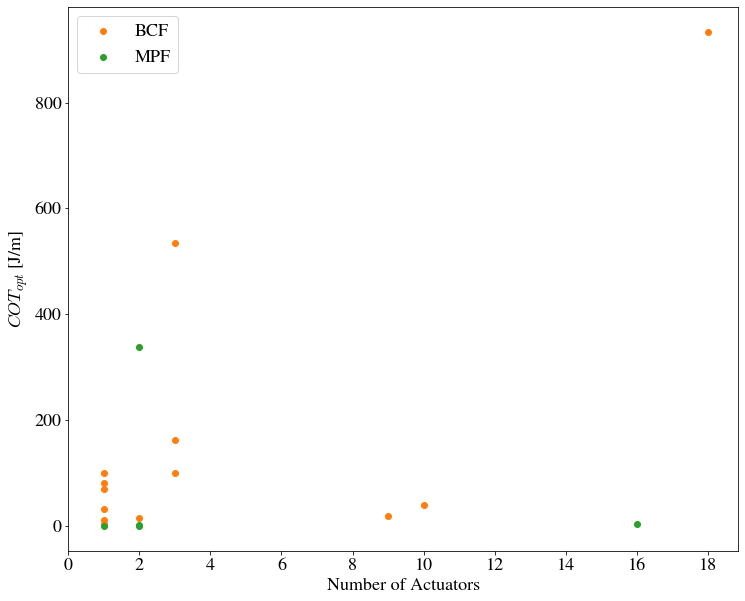

In [6]:
# plot COT and Number of actuators
fig2, ax2 = plt.subplots(figsize=(12,10), facecolor='w')
ax2.scatter(bcf_cot['NumberActuators'], bcf_cot['COTopt [J/m]'], color='C1', label='BCF')
ax2.scatter(mpf_cot['NumberActuators'], mpf_cot['COTopt [J/m]'], color='C2', label='MPF')
ax2.set_xlabel('Number of Actuators')
ax2.set_ylabel('$COT_{opt}$ [J/m]')
ax2.set_xticks(np.arange(0, 20, 2))
ax2.legend()

In [27]:
# fit the data to a linear scaling law fit
kinVisc = 1.31e-6
bcf_Re = np.multiply(bcfDF['Uopt [m/s]'].values, bcfDF['Length [m]'].values) / kinVisc
mpf_Re = np.multiply(mpfDF['Uopt [m/s]'].values, mpfDF['Length [m]'].values) / kinVisc

bcf_Sw = np.multiply(bcfDF['FlappingFrequency'].values*2*np.pi, bcfDF['FlappingAmplitude'].values, bcfDF['Length [m]'].values**2) / kinVisc
mpf_Sw = np.multiply(mpfDF['FlappingFrequency'].values*2*np.pi, mpfDF['FlappingAmplitude'].values, mpfDF['Length [m]'].values**2) / kinVisc

bcf = pd.DataFrame({'Sw': bcf_Sw, 'Re':bcf_Re})
mpf = pd.DataFrame({'Sw': mpf_Sw, 'Re':mpf_Re})

# do some data conditioning
bcf.dropna(inplace=True)
mpf.dropna(inplace=True)

bcf = bcf.loc[~(bcf==0).any(axis=1)]
mpf = mpf.loc[~(mpf==0).any(axis=1)]

# sort the column values in ascending order
bcf.sort_values('Sw', inplace=True)
mpf.sort_values('Sw', inplace=True)

In [38]:
inflection = 1e4

bcf_low = bcf[bcf['Sw'] <= inflection]
mpf_low = mpf[mpf['Sw'] <= inflection]

bcf_high = bcf[bcf['Sw'] > inflection]
mpf_high = mpf[mpf['Sw'] > inflection]

if len(bcf_low) > 2:
    bcf_fit_low, _ = fit_data(bcf_low['Sw'].values, bcf_low['Re'].values)
    bcf_fit_high, _ = fit_data(bcf_high['Sw'].values, bcf_high['Re'].values)
else:
    bcf_fit, _ = fit_data(np.log(bcf['Sw'].values), np.log(bcf['Re'].values))

if len(mpf_low) > 2:
    mpf_fit_low, _ = fit_data(mpf_low['Sw'].values, mpf_low['Re'].values)
    mpf_fit_high, _ = fit_data(mpf_high['Sw'].values, mpf_high['Re'].values)
else:
    mpf_fit, _ = fit_data(np.log(mpf['Sw'].values), np.log(mpf['Re'].values))

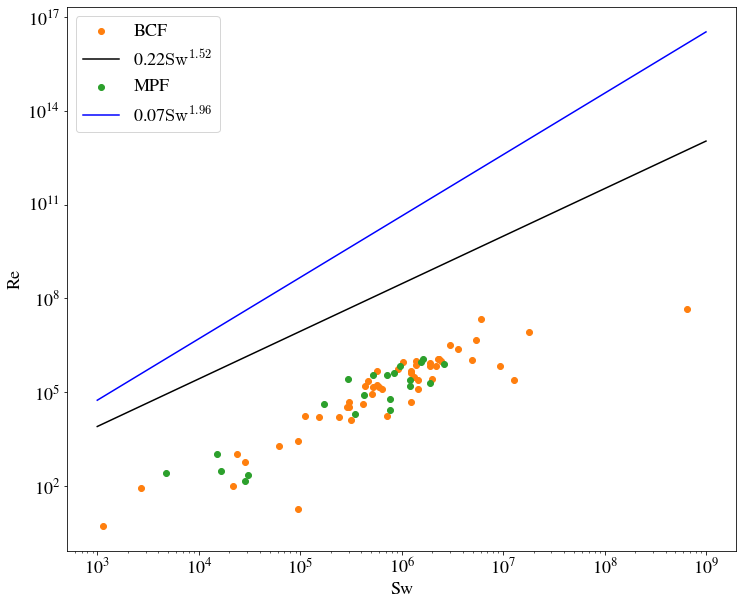

In [47]:
# plot Reynolds number and SW
fig3, ax3 = plt.subplots(figsize=(12,10), facecolor='w')
dx = np.linspace(1e3, 1e9, 20)

kinVisc = 1.31e-6

ax3.scatter(bcf['Sw'], bcf['Re'], color='C1', label='BCF')

if len(bcf_low) > 2:
    ax3.plot(dx,power_law(dx, *bcf_fit_low), 'k--')
    ax3.plot(dx, power_law(dx, *bcf_fit_high), 'k')
else:
    ax3.loglog(dx, power_law(dx, *bcf_fit), 'k', label=str(np.round(bcf_fit[0], 2)) + '$\mathrm{Sw^{' + str(np.round(bcf_fit[1],2)) + '}}$')


ax3.scatter(mpf['Sw'], mpf['Re'], color='C2', label='MPF')

if len(mpf_low) > 2:
    ax3.plot(dx, power_law(dx, *mpf_fit_low), 'b--')
    ax3.plot(dx, power_law(dx, *mpf_fit_high), 'b-')
else:
    ax3.plot(dx, power_law(dx, *mpf_fit), 'b', label=str(np.round(mpf_fit[0], 2)) + '$\mathrm{Sw^{' + str(np.round(mpf_fit[1],2)) + '}}$')

ax3.set_xlabel('Sw')
ax3.set_ylabel('Re')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.legend()